In [ ]:
!pip install diffusers transformers accelerate safetensors
!pip install git+https://github.com/tencent-ailab/IP-Adapter.git

  Cloning https://github.com/tencent-ailab/IP-Adapter.git to /tmp/pip-req-build-w549mxer
  Running command git clone --filter=blob:none --quiet https://github.com/tencent-ailab/IP-Adapter.git /tmp/pip-req-build-w549mxer
  Resolved https://github.com/tencent-ailab/IP-Adapter.git to commit 62e4af9d0c1ac7d5f8dd386a0ccf2211346af1a2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ip-adapter: filename=ip_adapter-0.1.0-py3-none-any.whl size=32685 sha256=2870ff0bd9b597dd44355dd23a968c6d495dc6257859d93cb91980c3c3a5af6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-6e2r9s8v/wheels/96/32/4d/f703ddfd0794868b989a766f963f572268b241063dba5ecddb
Successfully built ip-adapter


In [ ]:
import torch
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
from diffusers import StableDiffusionPipeline
from ip_adapter import IPAdapter

In [ ]:
clip_model = CLIPModel.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")
processor = CLIPProcessor.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
def preprocess_image(path):
    image = Image.open(path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    return inputs

def extract_features(path):
    inputs = preprocess_image(path)
    with torch.no_grad():
        emb = clip_model.get_image_features(**inputs)
    return emb

In [ ]:
emb_1 = extract_features("/content/unicorn.jpg")
emb_2 = extract_features("/content/dog2.jpg")


In [ ]:
alpha = 0.5
emb_mix = alpha * emb_1 + (1 - alpha) * emb_2


In [ ]:
!mkdir -p /content/ipadapter
!wget -O /content/ipadapter/ip-adapter_sd15.bin https://huggingface.co/h94/IP-Adapter/resolve/main/models/ip-adapter_sd15.bin
!wget -O /content/ipadapter/image_encoder.pth https://huggingface.co/h94/IP-Adapter/resolve/main/models/image_encoder.pth


--2025-09-08 07:55:46--  https://huggingface.co/h94/IP-Adapter/resolve/main/models/ip-adapter_sd15.bin
Resolving huggingface.co (huggingface.co)... 3.167.192.4, 3.167.192.6, 3.167.192.19, ...
Connecting to huggingface.co (huggingface.co)|3.167.192.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/6f/e5/6fe5d8840a1ab462e1b9f52fbeabac6bb30febaf56fb5a439f08cca6d1cf4372/68e1df30d760f280e578c302f1e73b37ea08654eff16a31153588047affe0058?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27ip-adapter_sd15.bin%3B+filename%3D%22ip-adapter_sd15.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1757321746&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1NzMyMTc0Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy82Zi9lNS82ZmU1ZDg4NDBhMWFiNDYyZTFiOWY1MmZiZWFiYWM2YmIzMGZlYmFmNTZmYjVhNDM5ZjA4Y2NhNmQxY2Y0MzcyLzY4ZTFkZjMwZDc2MGYyODBlNTc4YzMwMmYxZTczYjM3ZWEwODY1NGVmZjE2YTM

In [4]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()


In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")

image_encoder_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
ip_ckpt = "/content/ipadapter/ip-adapter_sd15.bin"
device = "cuda"



model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [ ]:
  adapter = IPAdapter(
      pipe,
      image_encoder_path,   # file image encoder
      ip_ckpt,            # file checkpoint
      device
  )


In [ ]:
images = adapter.generate(clip_image_embeds=emb_mix, num_images_per_step=100, seeds=500)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
def image_grid (imgs, rows, cols):
    assert len(imgs) == rows * cols

    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

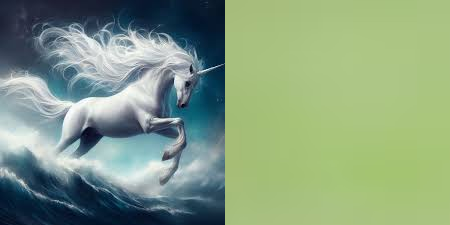

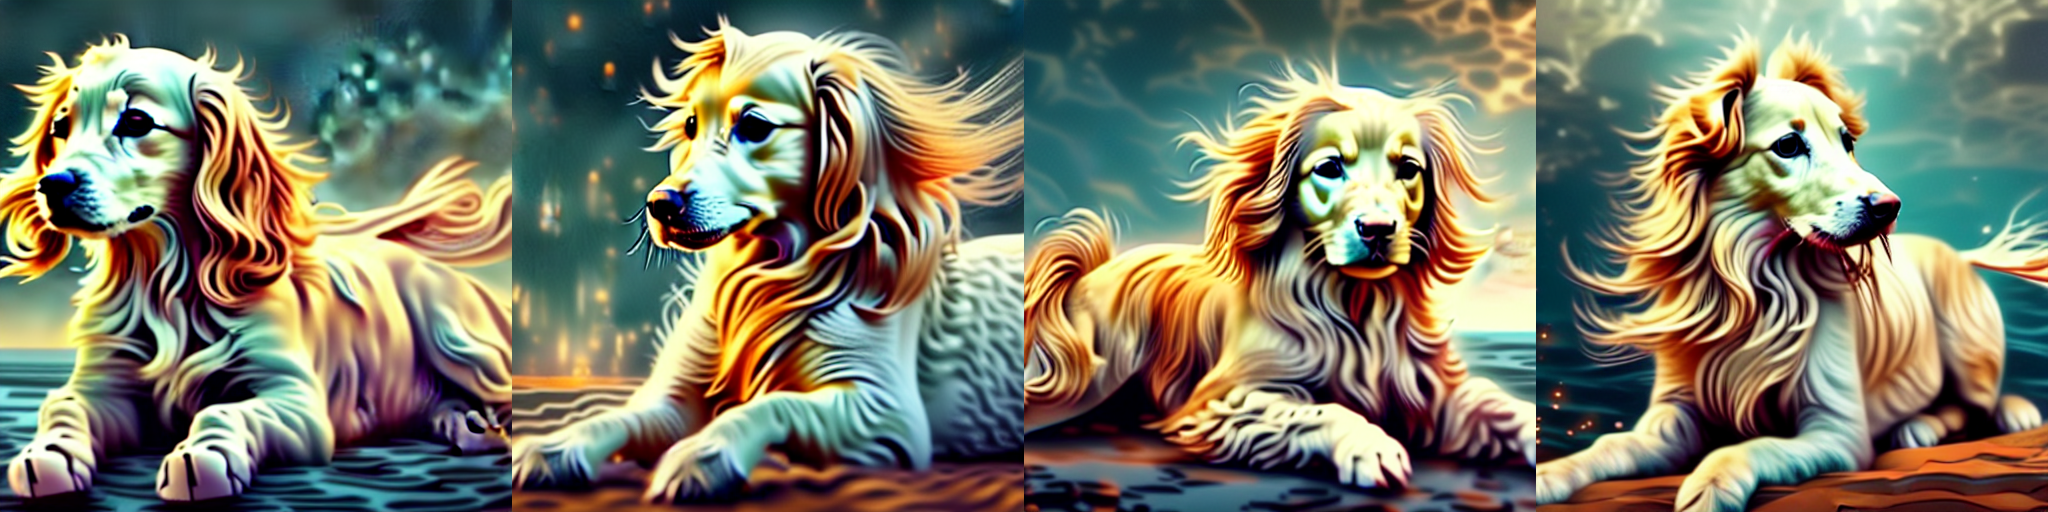

In [ ]:
grid = image_grid(images, 1, 4)
grid

In [2]:
!git config --global user.name "NguyenAn"
!git config --global user.email "an.s161459@gmail.com"

In [3]:
!git clone https://github.com/HuynhHanDong/fusion-image-generation.git

Cloning into 'fusion-image-generation'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), 93.18 KiB | 1.63 MiB/s, done.


In [4]:
%cd /content/fusion-image-generation/

/content/fusion-image-generation


In [6]:
!cp /content/projectOJT.ipynb .

cp: cannot stat '/content/projectOJT.ipynb': No such file or directory
